In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset
n_samples = 1500
n_classes = 5
n_features = 2

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, 
                  cluster_std=1.5, random_state=42)

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {n_classes}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (1500, 2)
Number of classes: 5
Class distribution: [300 300 300 300 300]


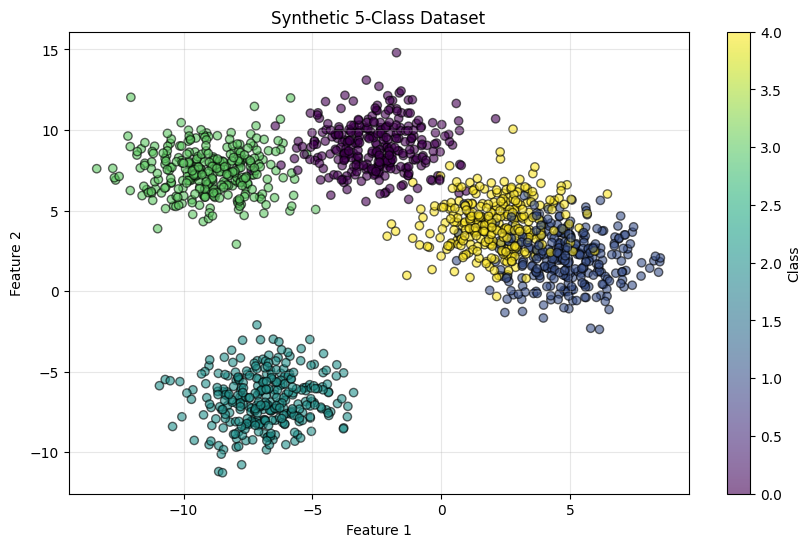

In [12]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6, edgecolors='k')
plt.colorbar(scatter, label='Class')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Synthetic 5-Class Dataset')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

print(f"Training set: {X_train.shape}, {y_train_encoded.shape}")
print(f"Test set: {X_test.shape}, {y_test_encoded.shape}")

Training set: (1200, 2), (1200, 5)
Test set: (300, 2), (300, 5)


In [14]:
class NeuralNetwork:
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size, learning_rate=0.01):
        """
        Initialize neural network with 3 hidden layers.
        
        Architecture: input -> hidden1 -> hidden2 -> hidden3 -> output
        """
        self.lr = learning_rate
        
        # Initialize weights with Xavier initialization
        self.W1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden1_size))
        
        self.W2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2.0 / hidden1_size)
        self.b2 = np.zeros((1, hidden2_size))
        
        self.W3 = np.random.randn(hidden2_size, hidden3_size) * np.sqrt(2.0 / hidden2_size)
        self.b3 = np.zeros((1, hidden3_size))
        
        self.W4 = np.random.randn(hidden3_size, output_size) * np.sqrt(2.0 / hidden3_size)
        self.b4 = np.zeros((1, output_size))
        
        self.losses = []
    
    def relu(self, Z):
        """ReLU activation function."""
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        """Derivative of ReLU."""
        return (Z > 0).astype(float)
    
    def softmax(self, Z):
        """Softmax activation for output layer."""
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Stability trick
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    
    def cross_entropy_loss(self, y_true, y_pred):
        """Calculate cross-entropy loss."""
        m = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)] + 1e-8)
        loss = np.sum(log_likelihood) / m
        return loss
    
    def forward(self, X):
        """Forward propagation through all layers."""
        # Layer 1
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        
        # Layer 2
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)
        
        # Layer 3
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.relu(self.Z3)
        
        # Output layer
        self.Z4 = np.dot(self.A3, self.W4) + self.b4
        self.A4 = self.softmax(self.Z4)
        
        return self.A4
    
    def backward(self, X, y_true, y_pred):
        """Backward propagation to compute gradients."""
        m = X.shape[0]
        
        # Output layer gradients
        dZ4 = y_pred - y_true
        dW4 = np.dot(self.A3.T, dZ4) / m
        db4 = np.sum(dZ4, axis=0, keepdims=True) / m
        
        # Hidden layer 3 gradients
        dA3 = np.dot(dZ4, self.W4.T)
        dZ3 = dA3 * self.relu_derivative(self.Z3)
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m
        
        # Hidden layer 2 gradients
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        # Hidden layer 1 gradients
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        # Update weights and biases
        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
    
    def train(self, X, y, epochs=1000, verbose=True):
        """Train the neural network."""
        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward(X)
            
            # Calculate loss
            loss = self.cross_entropy_loss(y, y_pred)
            self.losses.append(loss)
            
            # Backward pass
            self.backward(X, y, y_pred)
            
            # Print progress
            if verbose and (epoch + 1) % 100 == 0:
                accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
                print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")
    
    def predict(self, X):
        """Make predictions on new data."""
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

In [15]:
# Initialize network
nn = NeuralNetwork(
    input_size=2,
    hidden1_size=64,
    hidden2_size=32,
    hidden3_size=16,
    output_size=5,
    learning_rate=0.01
)

print("Training Neural Network...\n")
nn.train(X_train, y_train_encoded, epochs=1000, verbose=True)

Training Neural Network...

Epoch 100/1000 - Loss: 0.2026 - Accuracy: 0.9175
Epoch 200/1000 - Loss: 0.1969 - Accuracy: 0.9167
Epoch 300/1000 - Loss: 0.1943 - Accuracy: 0.9158
Epoch 400/1000 - Loss: 0.1924 - Accuracy: 0.9158
Epoch 500/1000 - Loss: 0.1908 - Accuracy: 0.9158
Epoch 600/1000 - Loss: 0.1894 - Accuracy: 0.9175
Epoch 700/1000 - Loss: 0.1882 - Accuracy: 0.9192
Epoch 800/1000 - Loss: 0.1870 - Accuracy: 0.9192
Epoch 900/1000 - Loss: 0.1859 - Accuracy: 0.9208
Epoch 1000/1000 - Loss: 0.1848 - Accuracy: 0.9217


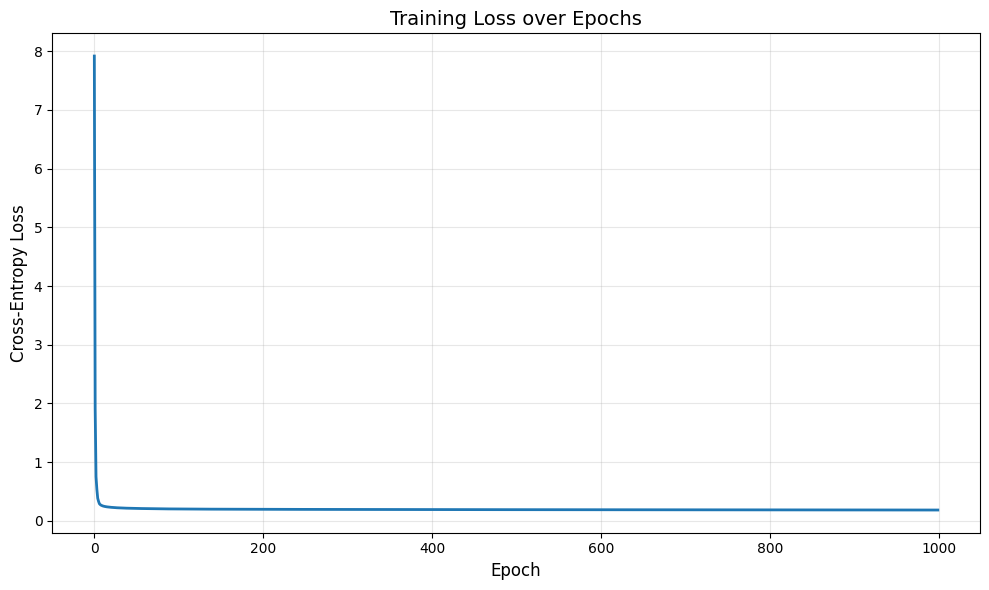

Final Training Loss: 0.1848


In [16]:
plt.figure(figsize=(10, 6))
plt.plot(nn.losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.title('Training Loss over Epochs', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {nn.losses[-1]:.4f}")

In [17]:
# Make predictions
y_pred_train = nn.predict(X_train)
y_pred_test = nn.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("=" * 50)
print("PERFORMANCE METRICS")
print("=" * 50)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\n" + "=" * 50)
print("CLASSIFICATION REPORT (Test Set)")
print("=" * 50)
print(classification_report(y_test, y_pred_test, target_names=[f'Class {i}' for i in range(n_classes)]))

PERFORMANCE METRICS
Training Accuracy: 0.9217
Test Accuracy: 0.9100

CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

     Class 0       0.91      0.91      0.91        58
     Class 1       0.91      0.75      0.82        52
     Class 2       1.00      1.00      1.00        70
     Class 3       0.94      0.98      0.96        66
     Class 4       0.77      0.85      0.81        54

    accuracy                           0.91       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.91      0.91       300



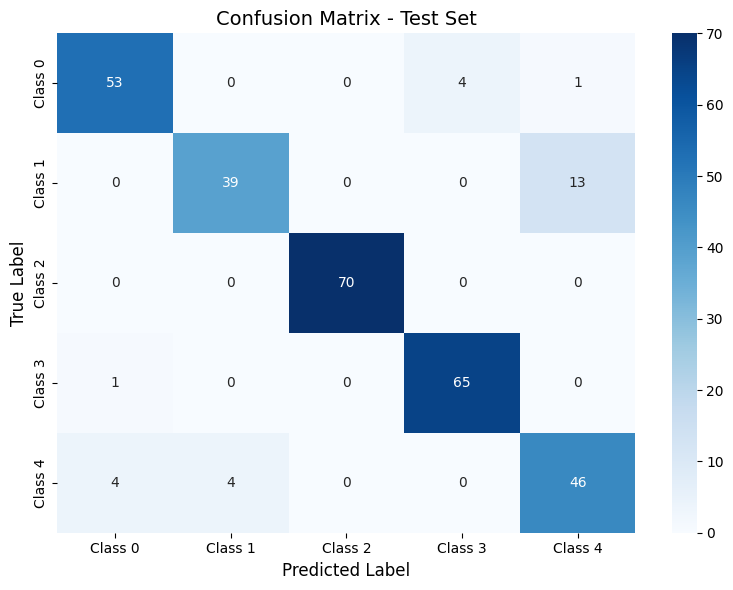

In [18]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i}' for i in range(n_classes)],
            yticklabels=[f'Class {i}' for i in range(n_classes)])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14)
plt.tight_layout()
plt.show()

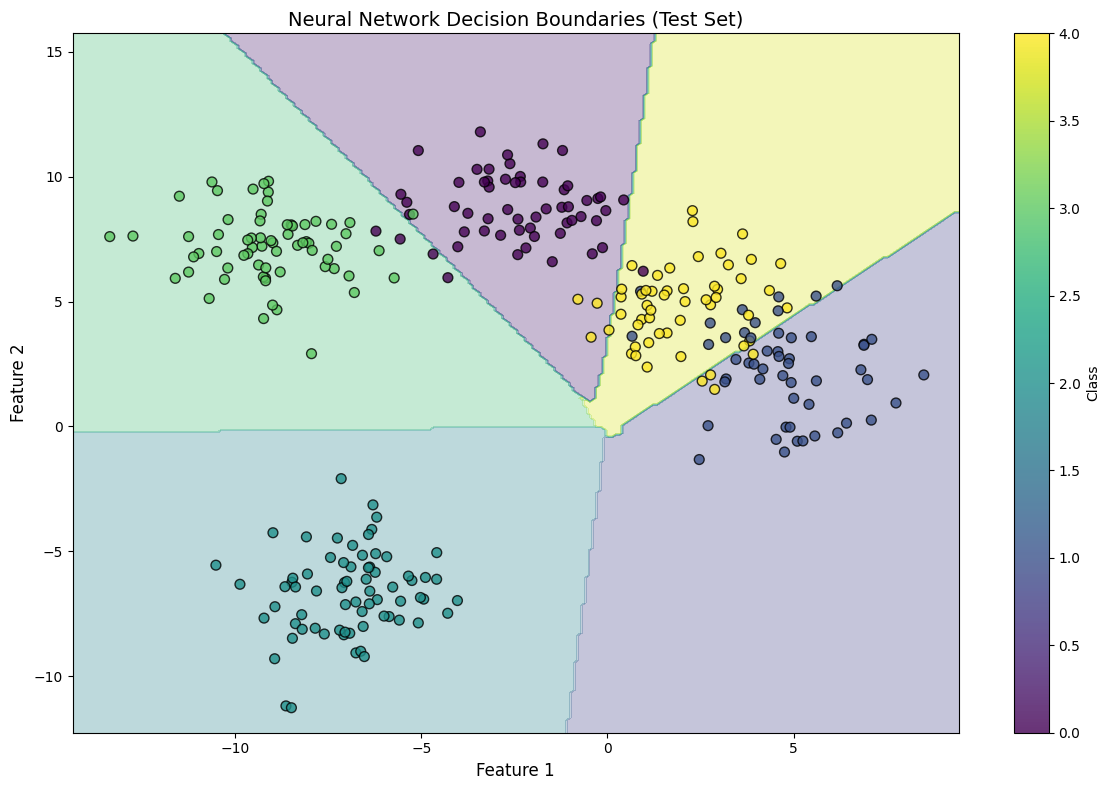

In [19]:
# Create mesh grid
h = 0.1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict on mesh
Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', 
                     edgecolors='k', s=50, alpha=0.8)
plt.colorbar(scatter, label='Class')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Neural Network Decision Boundaries (Test Set)', fontsize=14)
plt.tight_layout()
plt.show()

In [21]:
print("=" * 60)
print("NEURAL NETWORK ARCHITECTURE SUMMARY")
print("=" * 60)
print(f"{'Layer':<20} {'Shape':<25} {'Parameters':<15}")
print("-" * 60)

params_W1 = nn.W1.shape[0] * nn.W1.shape[1]
params_b1 = nn.b1.shape[1]
print(f"{'Input -> Hidden1':<20} {str(nn.W1.shape):<25} {params_W1 + params_b1:<15}")

params_W2 = nn.W2.shape[0] * nn.W2.shape[1]
params_b2 = nn.b2.shape[1]
print(f"{'Hidden1 -> Hidden2':<20} {str(nn.W2.shape):<25} {params_W2 + params_b2:<15}")

params_W3 = nn.W3.shape[0] * nn.W3.shape[1]
params_b3 = nn.b3.shape[1]
print(f"{'Hidden2 -> Hidden3':<20} {str(nn.W3.shape):<25} {params_W3 + params_b3:<15}")

params_W4 = nn.W4.shape[0] * nn.W4.shape[1]
params_b4 = nn.b4.shape[1]
print(f"{'Hidden3 -> Output':<20} {str(nn.W4.shape):<25} {params_W4 + params_b4:<15}")

total_params = (params_W1 + params_b1 + params_W2 + params_b2 + 
                params_W3 + params_b3 + params_W4 + params_b4)
print("-" * 60)
print(f"{'TOTAL PARAMETERS:':<45} {total_params:<15}")
print("=" * 60)

print("\nActivation Functions:")
print("  - Hidden Layers: ReLU")
print("  - Output Layer: Softmax")
print("\nOptimizer: Gradient Descent")
print(f"Learning Rate: {nn.lr}")
print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Final Test Accuracy: 0.9100 (91.00%)
